Autoencoder is a general encoding NN for representing data of high dimensions within spaces of lower dimensions, however it is mostly used in images, because of varying dimensions that depend on the resolution. It is a simple yet powerful framework for encoding images and other data that might just be inferior to ViT (https://github.com/lucidrains/vit-pytorch) (Vision Transformers). In general we use Auto Encoders (AE) when we want to **learn representations of highly dimensional data**. In this notebook we'll cover an implementation of the AE as well as showcase how wandb (https://wandb.ai/) can be used to log training results onto a shareable dashboard.

#### Mathematics behind the AE
* Given the input of features $X$, we initialize the encoder $h_e$ and decoder $h_d$ layer-functions.
* We compress our features to some lower dimension space by $z=f(h_e(x))$
* We then try reconstructing a space of higher dimensionality $X$ by decoding $\hat{X}=f(h_d(z))$, where $f$ is some activation function.
* We then optimize the weights of the model by calculating the gradient for the following loss function: $L(X,\hat{X})=MSE(X,\hat{X})$. We then repeat two previous steps until convergence.

#### Loading up data
A proper use case for AE's would be a classic MNIST dataset that we can load from `torchvision.datasets`

In [1]:
import torchvision
from torchvision import transforms
from torch.utils import data

transformations = torchvision.transforms.Compose([
    transforms.ToTensor(), transforms.Lambda(lambda x: x * 64)
])

train_ds, test_ds = torchvision.datasets.MNIST(root='./data/vision',
                                               train=True,
                                               transform=transformations,
                                               download=True), \
                    torchvision.datasets.MNIST(root='./data/vision',
                                               train=False,
                                               transform=transformations,
                                               download=True)

# pin_memory allows dedicated faster paging of the data
# between CPU and GPU: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/#pinned_host_memory
train_dl, test_dl = data.DataLoader(train_ds, 64, shuffle=True, pin_memory=True), \
    data.DataLoader(test_ds, 64, shuffle=False)

len(train_dl), len(test_dl)

(938, 157)

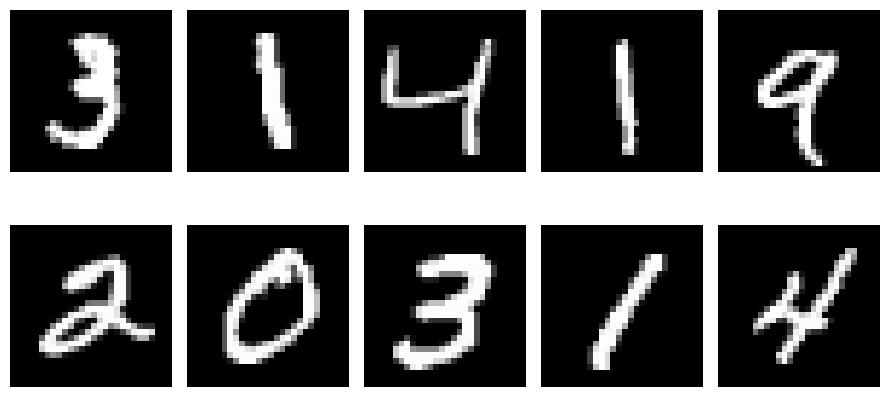

In [2]:
import matplotlib.pyplot as plt

rows, cols = 2, 5
fig, axs = plt.subplots(rows,cols,figsize=(9,5))
for i, (img, label) in enumerate(train_ds):
    x, y = i % cols, i % rows
    axs[y, x].imshow(img[0], cmap="gray")
    axs[y, x].axis('off')
    if i == 10:
        break
fig.tight_layout()

#### Building an Auto Encoder framework

In [7]:
import torch
from torch import nn

class AE(nn.Module):

    def __init__(self, k, dropout=.01, input_shape=64, *args, **kwargs) -> None:
        """ 
        - k: int
            - Number of latent factors
        - dropout: float
            - Dropout rate
        """

        super().__init__(*args, **kwargs)
        self.k = k
        self.dropout = dropout
        self.input_shape = input_shape

        self.e_proj = nn.Linear(
            input_shape, k)
        self.encfc = nn.Linear(k, k)
        self.enc_dec_proj = nn.Linear(k, k)
        self.d_out = nn.Linear(
            k, input_shape)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.e_proj(x)
        x = self.gelu(x)
        x = self.encfc(x)
        x = self.relu(x)
        x = self.enc_dec_proj(x)
        x = self.gelu(x)
        return self.gelu(self.d_out(x))

#### Training the AE model
We'll initialize our AE model with $H_{image}\times W_{image}$ number of input parameters and $k=32$ latent factors

In [8]:
imgDims = torch.prod(torch.tensor(train_ds[0][0][0].shape), 0).item()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
aeModel = AE(k=32,input_shape=imgDims).to(device)
print(f'latent_factors=32 :: input={imgDims}')
aeModel

latent_factors=32 :: input=784


AE(
  (e_proj): Linear(in_features=784, out_features=32, bias=True)
  (encfc): Linear(in_features=32, out_features=32, bias=True)
  (enc_dec_proj): Linear(in_features=32, out_features=32, bias=True)
  (d_out): Linear(in_features=32, out_features=784, bias=True)
  (gelu): GELU(approximate='none')
  (relu): ReLU()
  (drop): Dropout(p=0.01, inplace=False)
)

Initialize training parameters, Adam optimizer and MSE as a loss function

In [9]:
trainParams = {
    'lr': .001,
    'max_epochs': 20,
    'momentum': .08,
    'w_decay': .05,
    'verbose': 1,
    'wandb_rundir': 'mlfromscratch'
}

optimizer = torch.optim.SGD(aeModel.parameters(), 
                             lr=trainParams['lr'],
                             momentum=trainParams['momentum'],
                             weight_decay=trainParams['w_decay'])
criterion = nn.MSELoss().to(device)

Connect to wandb, initialize the training state and start the training sequence

In [30]:
!wandb login

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\user/.netrc


In [10]:
from tqdm import tqdm
from sklearn.metrics import r2_score
import numpy as np
import wandb

# connecting to Wandb
wandb.init(
    project=trainParams['wandb_rundir'],
    config={
    "learning_rate": trainParams['lr'],
    "architecture": "AE_w_SGD",
    "dataset": "MNIST",
    "epochs": trainParams['max_epochs'],
    }
)

r2Scores = []
avMSEs = []

for epoch in range(trainParams['max_epochs']):
    MSEs = []
    x, xHat = [], []
    for (img, label) in tqdm(train_dl):
        img = img.view(-1,imgDims).to(device)

        # we're zeroing gradients, because by 
        # default they're being accumulated,
        # which is not needed for AE, unlike
        # RNNs or other sequential models
        optimizer.zero_grad()

        out = aeModel(img)
        loss = criterion(out, img)
        MSEs.append(loss.item())

        loss.backward()
        optimizer.step()

        # collecting samples for R^2
        x.append(img.cpu().detach().numpy())
        xHat.append(out.cpu().detach().numpy())

    avMSEs.append(np.array(MSEs).mean())
    r2Scores.append(r2_score(np.vstack(x),np.vstack(xHat)))

    # log to Wandb and locally
    wandb.log({"av. loss": avMSEs[-1], "R^2": r2Scores[-1]})
    if epoch % trainParams['verbose'] == 0:
        print(f'epoch: {epoch+1} :: av. MSE:',avMSEs[-1],':: R^2:',r2Scores[-1])

# disconnecting from Wandb
wandb.finish()

del MSEs
del x
del xHat

100%|██████████| 938/938 [00:09<00:00, 98.42it/s] 


epoch: 1 :: av. MSE: 268.9018289854786 :: R^2: -55.023985635326355


100%|██████████| 938/938 [00:09<00:00, 102.55it/s]


epoch: 2 :: av. MSE: 181.7204006821362 :: R^2: -7.375387106388121


100%|██████████| 938/938 [00:09<00:00, 98.48it/s] 


epoch: 3 :: av. MSE: 158.25631626023412 :: R^2: -4.07497247362079


100%|██████████| 938/938 [00:09<00:00, 98.16it/s] 


epoch: 4 :: av. MSE: 144.29465101522678 :: R^2: -2.911617399889868


100%|██████████| 938/938 [00:09<00:00, 97.65it/s] 


epoch: 5 :: av. MSE: 134.055409714103 :: R^2: -1.816583730572674


100%|██████████| 938/938 [00:09<00:00, 98.47it/s] 


epoch: 6 :: av. MSE: 128.71417832527078 :: R^2: -0.6447194068447129


100%|██████████| 938/938 [00:09<00:00, 98.61it/s] 


epoch: 7 :: av. MSE: 124.45304657502977 :: R^2: -0.3100520693304221


100%|██████████| 938/938 [00:09<00:00, 99.34it/s] 


epoch: 8 :: av. MSE: 118.43794647412005 :: R^2: -0.26925846224607924


100%|██████████| 938/938 [00:09<00:00, 99.05it/s] 


epoch: 9 :: av. MSE: 115.26843040482576 :: R^2: -0.22266001995265963


100%|██████████| 938/938 [00:09<00:00, 97.70it/s] 


epoch: 10 :: av. MSE: 112.61517656891584 :: R^2: -0.12777288955142896


100%|██████████| 938/938 [00:09<00:00, 100.02it/s]


epoch: 11 :: av. MSE: 110.80460048586066 :: R^2: 0.07288400458778525


100%|██████████| 938/938 [00:09<00:00, 98.51it/s] 


epoch: 12 :: av. MSE: 107.80253993117734 :: R^2: 0.1235807244564518


100%|██████████| 938/938 [00:09<00:00, 96.93it/s] 


epoch: 13 :: av. MSE: 105.07220629791715 :: R^2: 0.17738215606928587


100%|██████████| 938/938 [00:09<00:00, 97.92it/s] 


epoch: 14 :: av. MSE: 103.8130884150198 :: R^2: 0.17710291981742587


100%|██████████| 938/938 [00:09<00:00, 94.58it/s] 


epoch: 15 :: av. MSE: 102.99031497166355 :: R^2: 0.1866155844508478


100%|██████████| 938/938 [00:09<00:00, 96.98it/s] 


epoch: 16 :: av. MSE: 102.07903761548528 :: R^2: 0.21429946063114153


100%|██████████| 938/938 [00:09<00:00, 102.99it/s]


epoch: 17 :: av. MSE: 101.18222511958466 :: R^2: 0.2314931614023864


100%|██████████| 938/938 [00:08<00:00, 107.47it/s]


epoch: 18 :: av. MSE: 99.24858049339831 :: R^2: 0.24293359643905565


100%|██████████| 938/938 [00:09<00:00, 99.64it/s] 


epoch: 19 :: av. MSE: 95.51888646042423 :: R^2: 0.26694530670995786


100%|██████████| 938/938 [00:09<00:00, 100.25it/s]


epoch: 20 :: av. MSE: 94.09942153572781 :: R^2: 0.27904957547200143


R^2,▁▇▇█████████████████
av. loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
R^2,0.27905
av. loss,94.09942


Following two runs, first using Adam (in green on the dashboard), and the second - SGD with momentum and L2 regularization (in purple), the second one has proven to be converging faster and has yeilded overall better results on the training set:

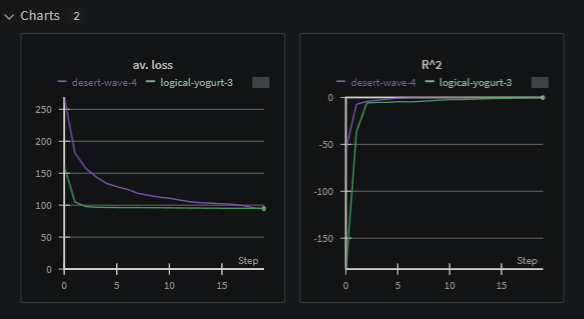

Wandb is also great for tracking GPU resources in real time, which could come in handy when, e.g., finetuning large models:

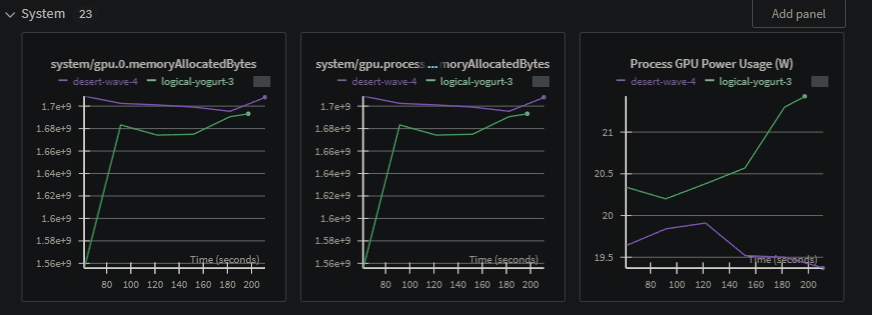

#### Now we can test out the AE on some test samples
As we can see, AE is able to pretty accurately reconstruct images based on only $32$ latent factors

In [16]:
def reconstruct(img):
    """ 
    Compress and reconstruct an image
    """

    aeModel.eval()

    with torch.no_grad():
        imgAsVec = img.view(-1, imgDims).to(device)
        out = aeModel(imgAsVec)

    aeModel.train()
    return out.cpu().detach().view(28, 28)

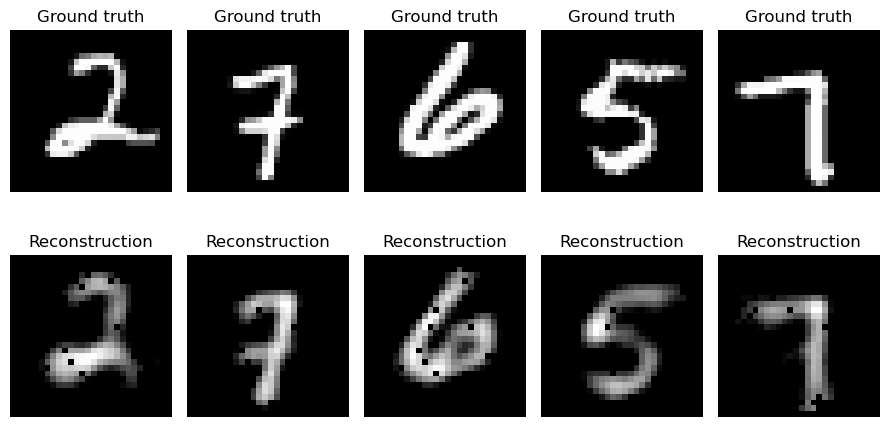

In [18]:
randomImages = torch.randint(0,len(test_ds),(5,))

fig, axs = plt.subplots(2,5,figsize=(9,5))
for i, imgIdx in enumerate(randomImages):
    img = test_ds[imgIdx][0][0]
    col = i % 5
    axs[0, col].imshow(img, cmap='gray')
    axs[0, col].set(title='Ground truth')
    axs[0, col].axis('off')
    axs[1, col].imshow(reconstruct(img), cmap='gray')
    axs[1, col].set(title='Reconstruction')
    axs[1, col].axis('off')
fig.tight_layout()